In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import shared

%config InlineBackend.figure_formats = ['retina']
plt.rc('font', size=12)
plt.style.use('seaborn-darkgrid')

In [3]:
# 1. generate the artificial dataset.
N = 100
NUM_FACTORS = 15
N_PER_FACTOR = N // NUM_FACTORS

COMMON_BETA_MU = 5.6
COMMON_ALPHA_MU = 1.0
COMMON_SD = 0.1

In [4]:
factors = []
for _ in range(NUM_FACTORS):
    Bmu = np.random.normal(COMMON_BETA_MU, COMMON_SD)
    Amu = np.random.normal(COMMON_ALPHA_MU, COMMON_SD)

    factors.append([Amu, Bmu])

In [5]:
factors

[[0.9992190555392831, 5.668720219095857],
 [1.1962033413457083, 5.451501543071832],
 [1.0569253877871079, 5.6108045512457245],
 [1.2496486334419687, 5.692685436733936],
 [1.0596554843533148, 5.69725939957079],
 [0.989002058670129, 5.569372418335819],
 [1.00477192409177, 5.587800167836624],
 [0.9670006178832293, 5.670476633460739],
 [0.9498640919284146, 5.458641837751674],
 [0.9913672836633656, 5.545646454575695],
 [1.1392125003431364, 5.761731570531949],
 [1.1526181714456294, 5.473397658219299],
 [0.8019181086140992, 5.628057602213067],
 [0.9619760475496376, 5.824759865607018],
 [0.9686557876514976, 5.539172246685816]]

In [8]:
Y = None
X = None
factor_indices = None

In [9]:
for f_idx, f in enumerate(factors):
    innovation = np.reshape(np.random.normal(0.0, 0.01, N_PER_FACTOR), [-1, 1])

    indices = np.ones_like(innovation) * f_idx
    y = (f[1] * innovation) + f[0]

    if X is None:
        X = innovation
        factor_indices = indices
        Y = y
    else:
        X = np.concatenate((X, innovation), axis=0)
        factor_indices = np.concatenate((factor_indices, indices), axis=0)
        Y = np.concatenate((Y, y), axis=0)

In [11]:
X_shared = shared(X)
Y_shared = shared(Y)

In [12]:
with pm.Model() as exercise4_unpooled:

    a = pm.Normal('a', mu=1, sd=.5, shape=NUM_FACTORS)
    b = pm.Normal('b', mu=5, sd=.5, shape=NUM_FACTORS)

    expected_value = (b[factor_indices.astype(int)] * X_shared) + a[factor_indices.astype(int)]
    y = pm.Normal('y', expected_value, observed=Y_shared)

In [13]:
with exercise4_unpooled:
    trace = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:11<00:00, 1349.16draws/s]


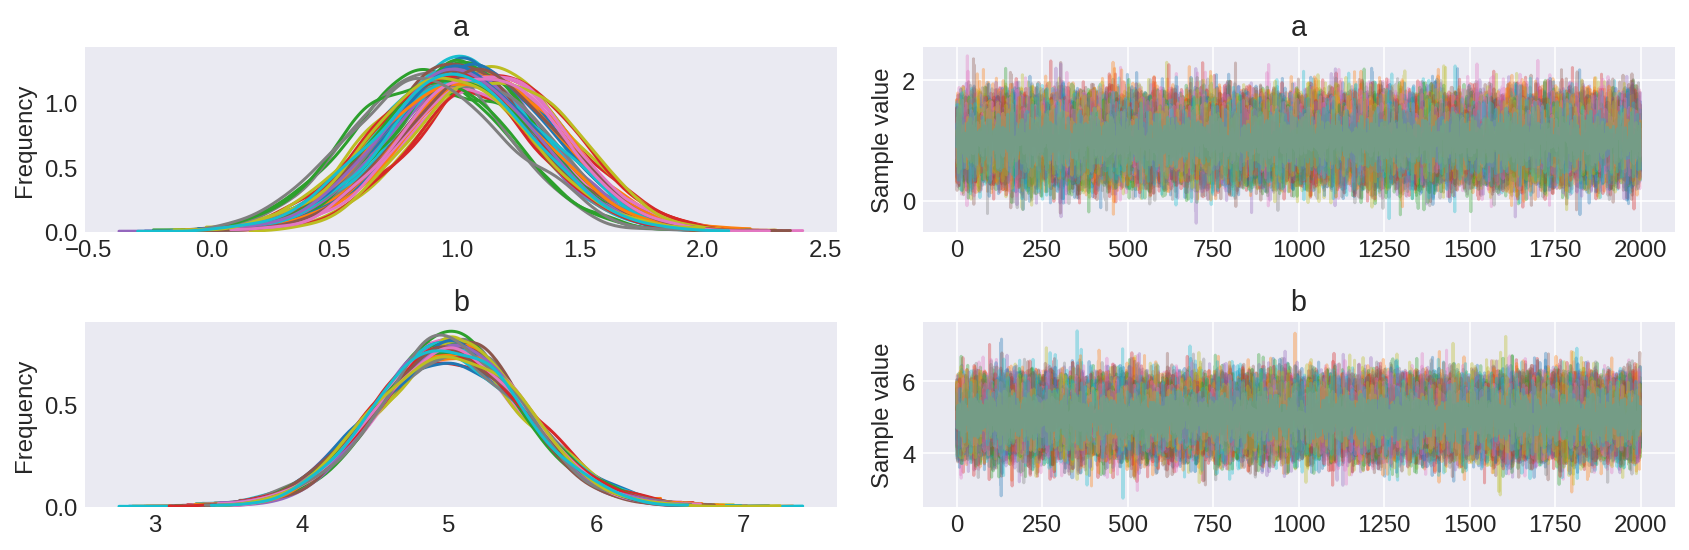

In [14]:
pm.traceplot(trace, ['a', 'b']);

In [15]:
samples = pm.sample_ppc(trace, model=exercise4_unpooled, size=1000)
y_preds = np.mean(samples['y'], axis=1)

print("y_preds shape = ", y_preds.shape)
print("Y shape = ", Y.shape)

# print "y_preds = ", y_preds[:10]
# print "Y = ", Y[:10]

RMSD = np.sqrt(np.mean((y_preds - Y) ** 2.0))
print( "RMSD of unpooled model: ", RMSD)

100%|██████████| 2000/2000 [00:46<00:00, 43.28it/s]


y_preds shape =  (2000, 90, 1)
Y shape =  (90, 1)
RMSD of unpooled model:  0.31982009591353616


In [16]:
with pm.Model() as exercise4_pooled:

    mu_a = pm.Normal('mu_a', 1, sd=10, shape=1)
    sigma_a = pm.HalfNormal('sigma_a', sd=.5)
    mu_b = pm.Normal('mu_b', 5, sd=10, shape=1)
    sigma_b = pm.HalfNormal('sigma_b', sd=.5)

    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=NUM_FACTORS)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=NUM_FACTORS)

    expected_value = (b[factor_indices.astype(int)] * X_shared) + a[factor_indices.astype(int)]
    y = pm.Normal('y', expected_value, observed=Y_shared)

In [17]:
with exercise4_pooled:
    trace = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 16000/16000 [02:43<00:00, 30.64draws/s] 
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
There were 456 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6259924634362143, but should be close to 0.8. Try to increase the number of tuning steps.
There were 339 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7027851776557139, but should be close to 0.8. Try to increase the number of tuning steps.
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


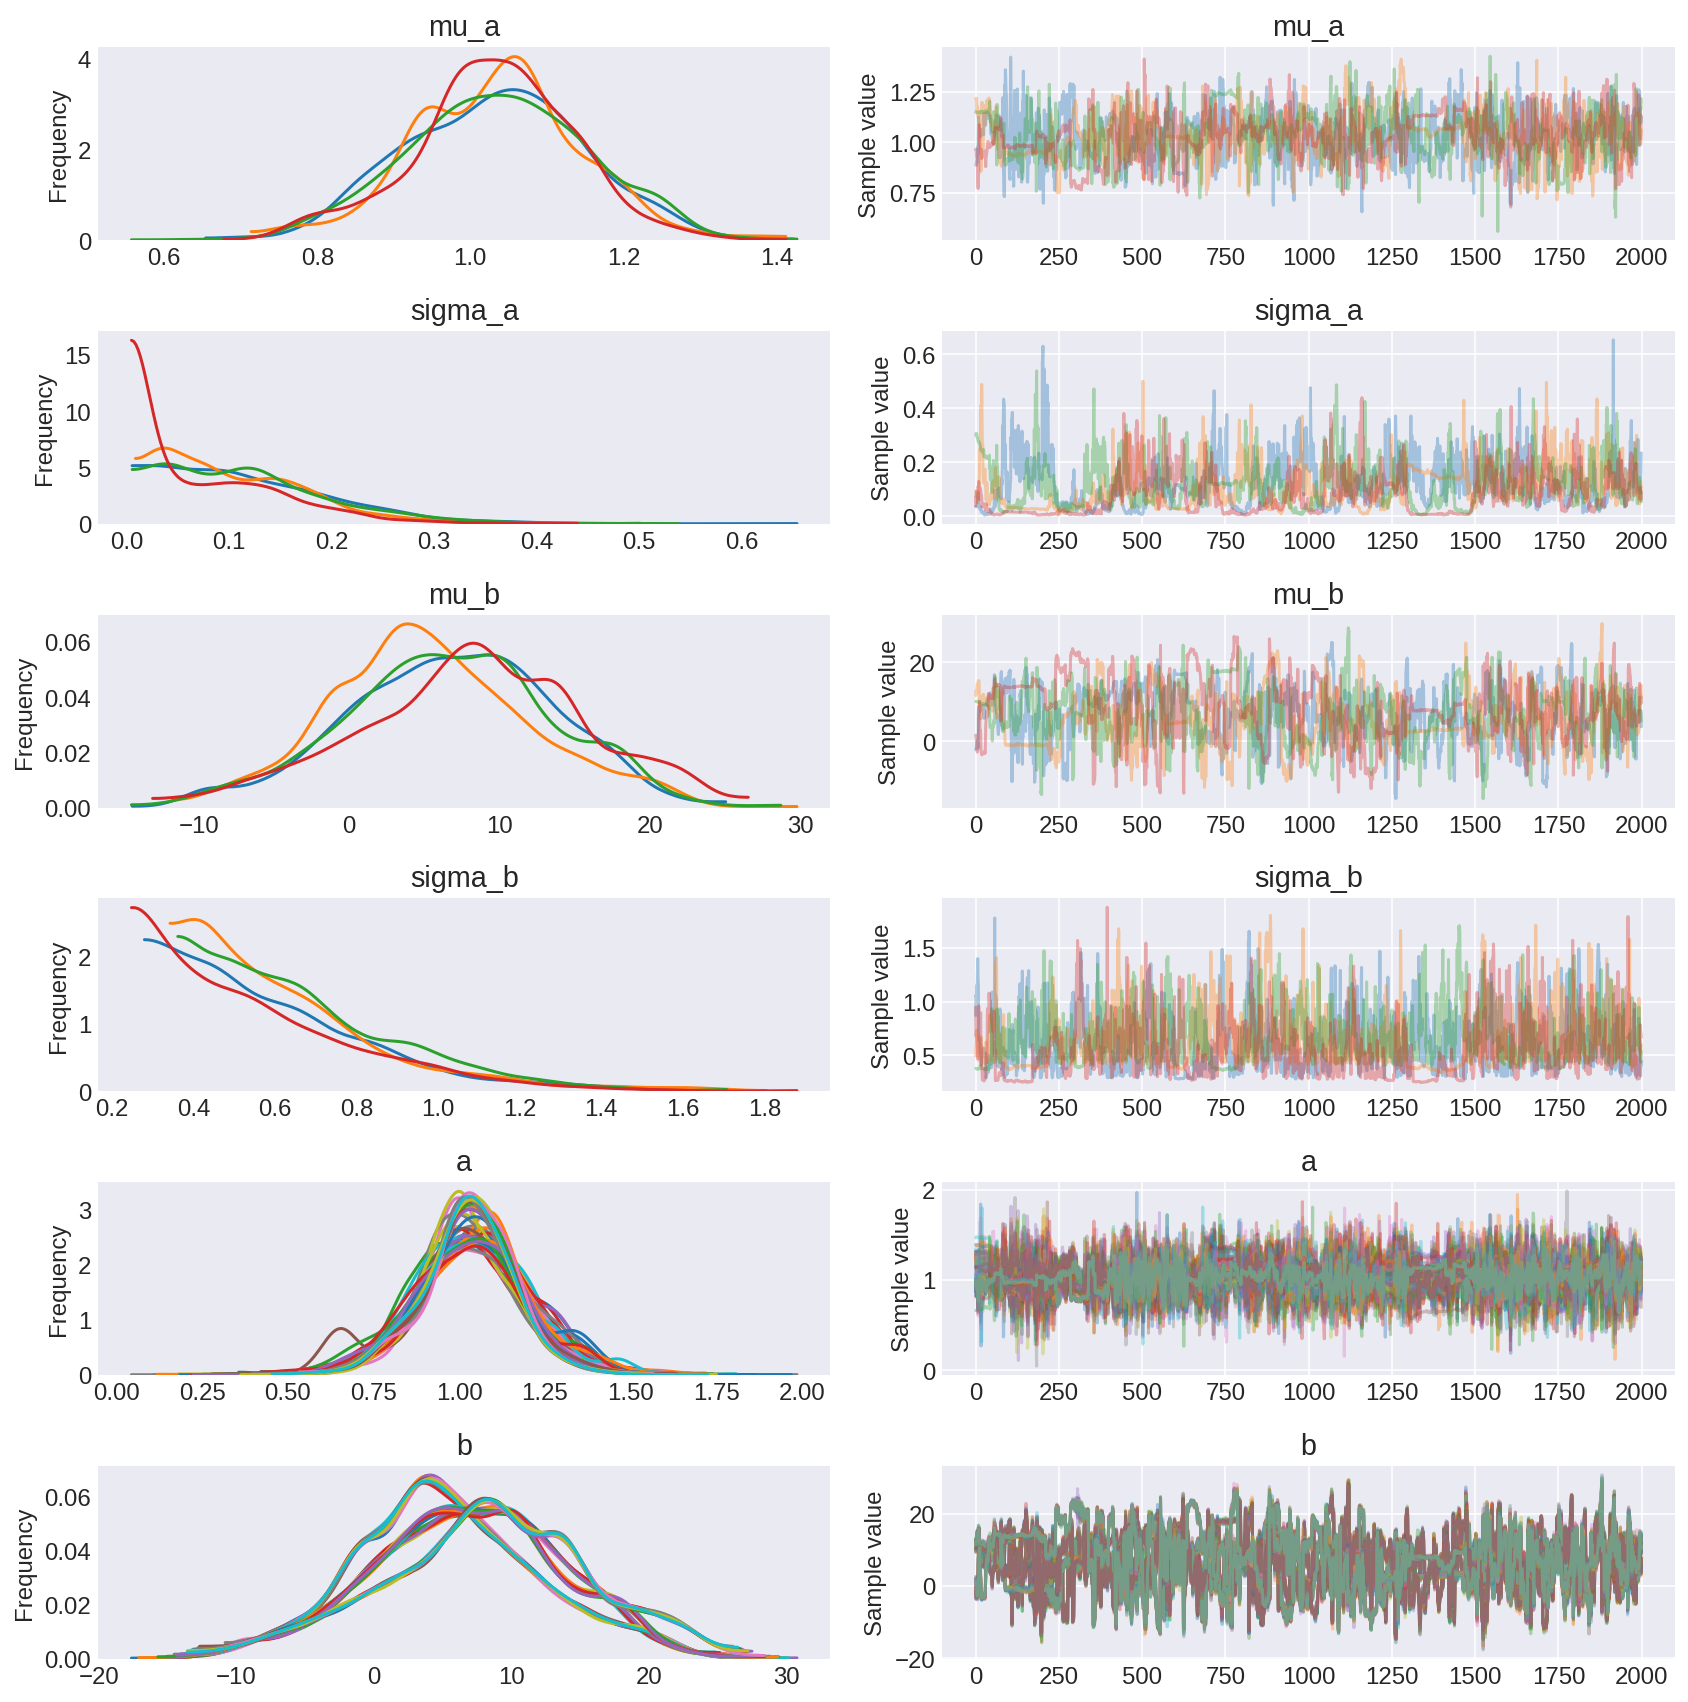

In [18]:
pm.traceplot(trace, ['mu_a', 'sigma_a', 'mu_b', 'sigma_b', 'a', 'b']);

In [19]:
# evaluate model accuracy
samples = pm.sample_ppc(trace, model=exercise4_pooled, size=1000)
y_preds = np.mean(samples['y'], axis=1)

RMSD = np.sqrt(np.mean((y_preds - Y) ** 2.0))
print( "RMSD of hierarchical model: ", RMSD)

100%|██████████| 2000/2000 [00:46<00:00, 43.26it/s]


RMSD of hierarchical model:  0.2040276088322923
